In [1]:
from sasha_tools import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('sample.csv', sep = ';')

In [5]:
#Make date and time features
df['date'] = pd.to_datetime(df['APPDATE'].apply(lambda x : str(x)[:10]), format = '%d.%m.%Y')
df['hour'] = pd.to_datetime(df['APPDATE'].apply(lambda x : str(x)[11:]), format = '%H:%M:%S', errors = 'coerce').dt.hour
df['date_full'] = df['date'].astype(str) + ' ' + pd.to_datetime(df['APPDATE'].apply(lambda x : str(x)[11:]), format = '%H:%M:%S', errors = 'coerce').astype(str).apply(lambda x : str(x)[-8:])
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.year * 10 + df['date'].dt.quarter
df['month'] = df['date'].dt.year * 10 + df['date'].dt.month


#Split dataset on train and test. Model wouldn't count yearly+ seasons, as we have only a year of data. 
# Also assume, that model is calibrated, so we have to worry only about ranking power of our model on a test data, not a mean fit
#Take a last quarter for a backtesting

train_indx = (df['date'] <= '2022-03-31')
'Fraction of train is: ', round(train_indx.mean(), 3)

('Fraction of train is: ', 0.803)

In [6]:
#Lets make some user/aggregation/history features
#We wouldn't lookup for the previous defaults, as they can be reached after new application sign and will lead to overfitting
#We will make pure retro-features with the info, available on the date of application 

df.sort_values(['DOCSERNUM', 'date_full'], inplace = True)

df['APP_rank_by_DOC'] = df.groupby('DOCSERNUM')['date'].rank(method = 'dense') #number of application by the same document (on the date of application, dont lookup to future)



df['LIM_num'] = df['LIM'].apply(lambda x : str(x).replace(',', '.')).apply(float)
df['LIM_CUMSUM_by_DOC'] = df.groupby('DOCSERNUM')['LIM_num'].cumsum() #sum of LIM by all previous + current applications
df['LIM_CUMSUM_by_DOC_prev'] = df['LIM_CUMSUM_by_DOC'] - df['LIM_num'] #sum of LIM by only previous applications \


df['EMAIL_str'] = df['EMAIL'].astype(str)
df['EMAIL_int'] = df['EMAIL'].apply(lambda x : x.replace('EMAIL', '')).astype(int)

df['EMAIL_num_by_DOC'] = df.groupby('DOCSERNUM').expanding()['EMAIL_int'].apply(lambda x : len(set(x))).values #Number of emails by a document

In [9]:
df_copy = df[train_indx].copy(deep = True)

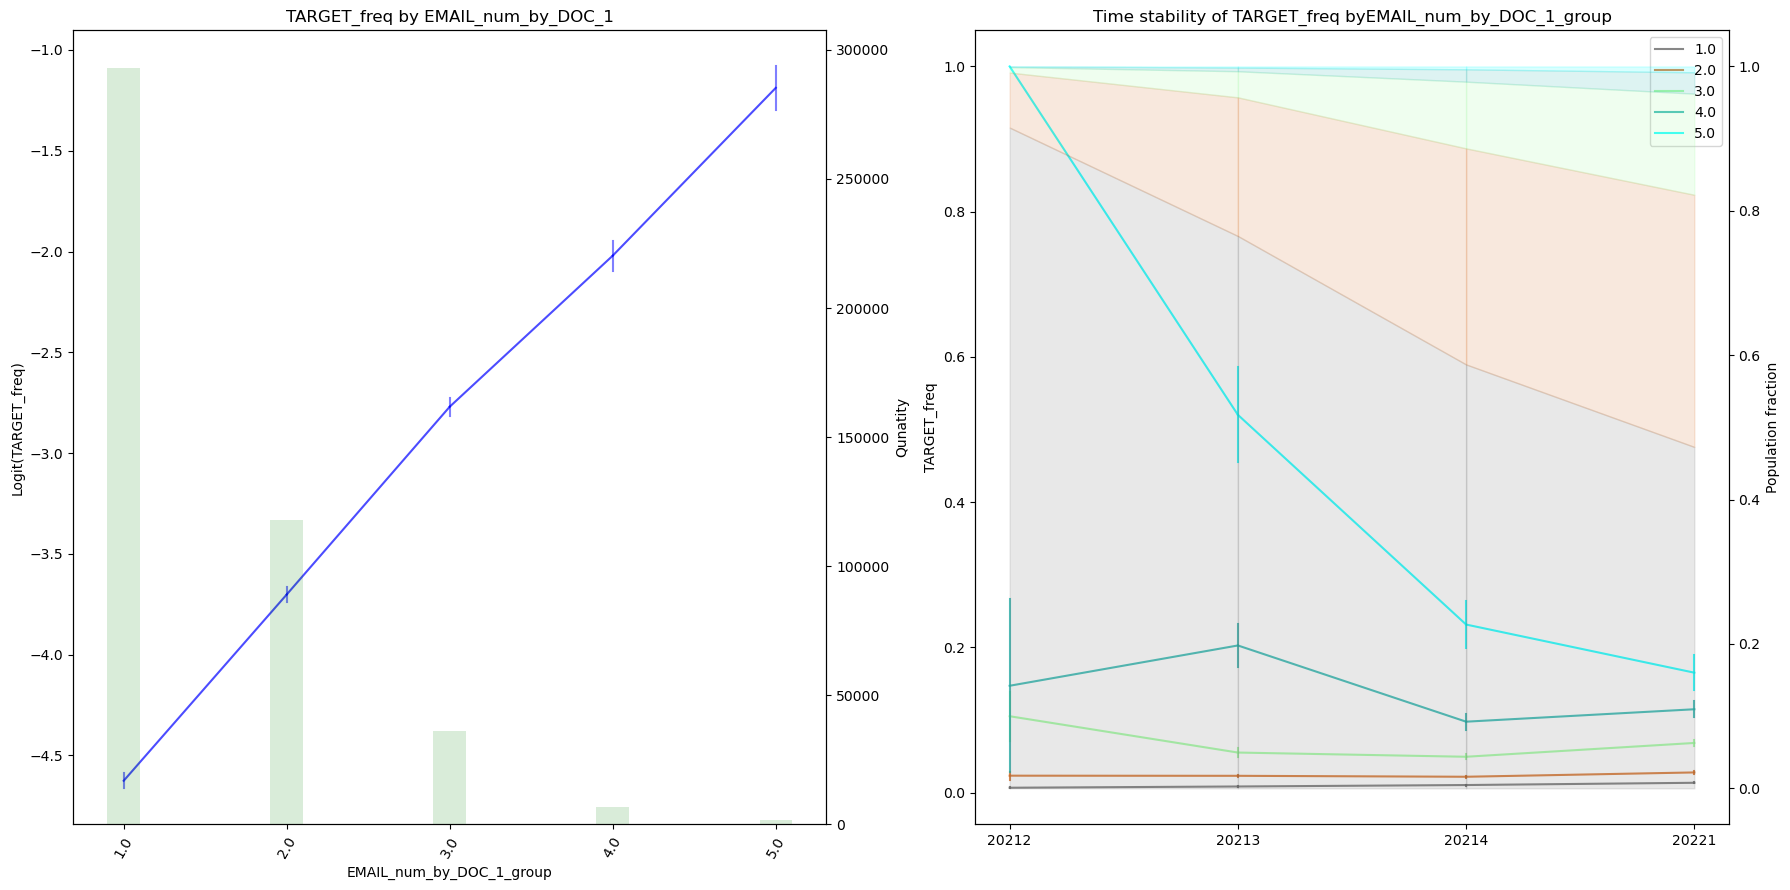

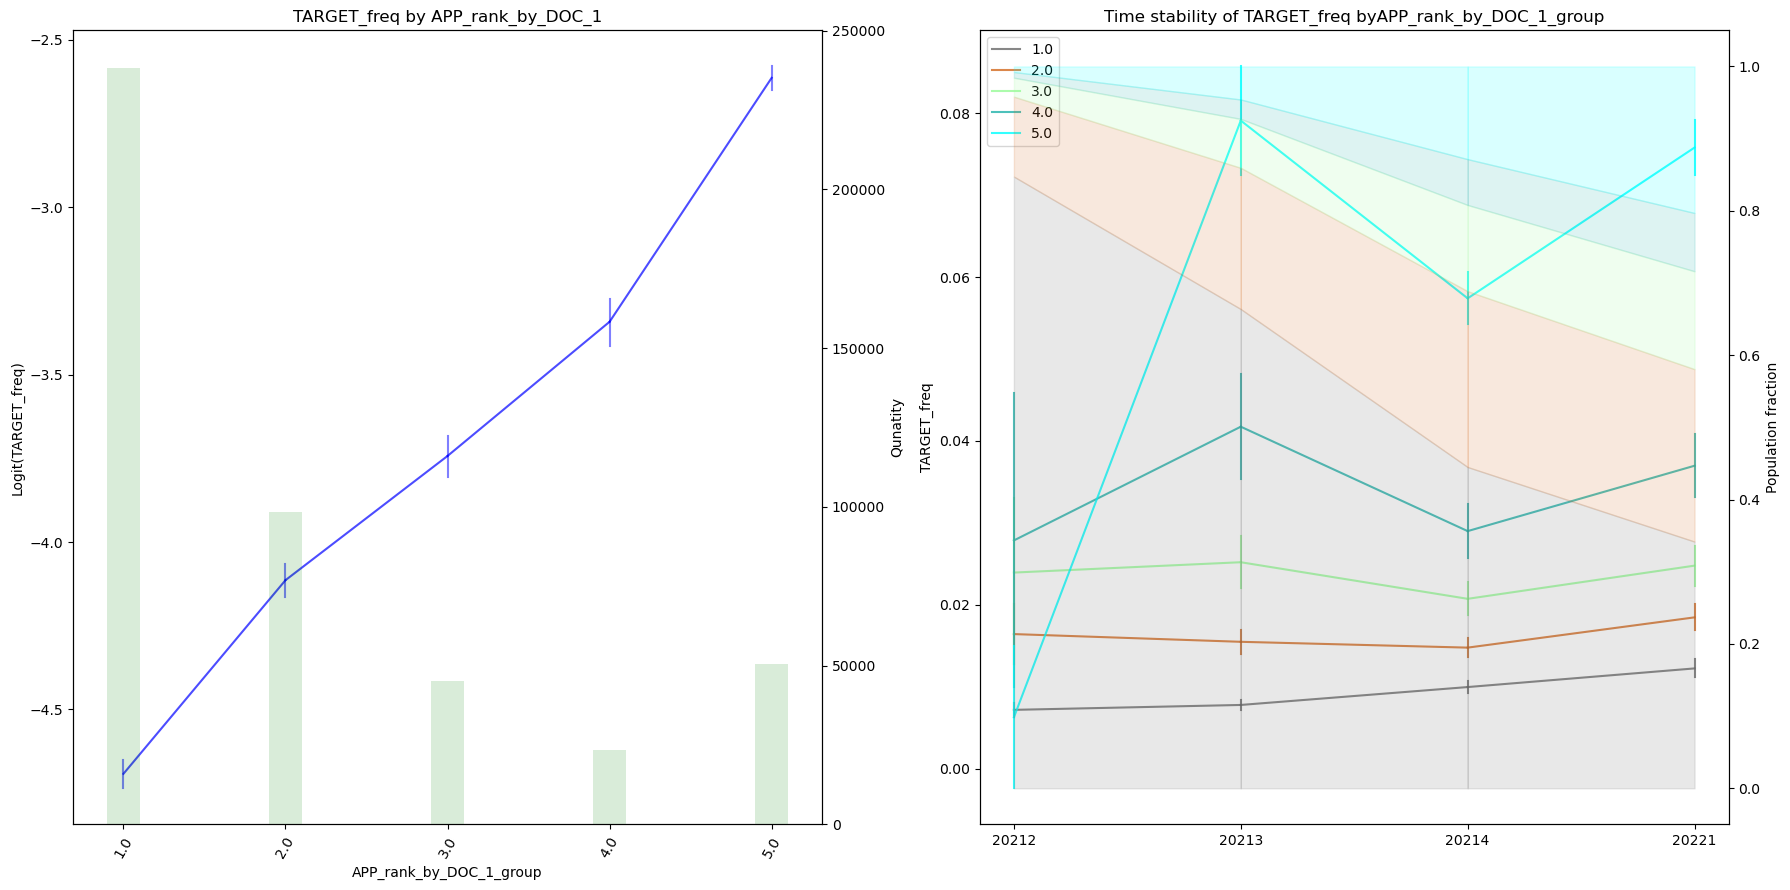

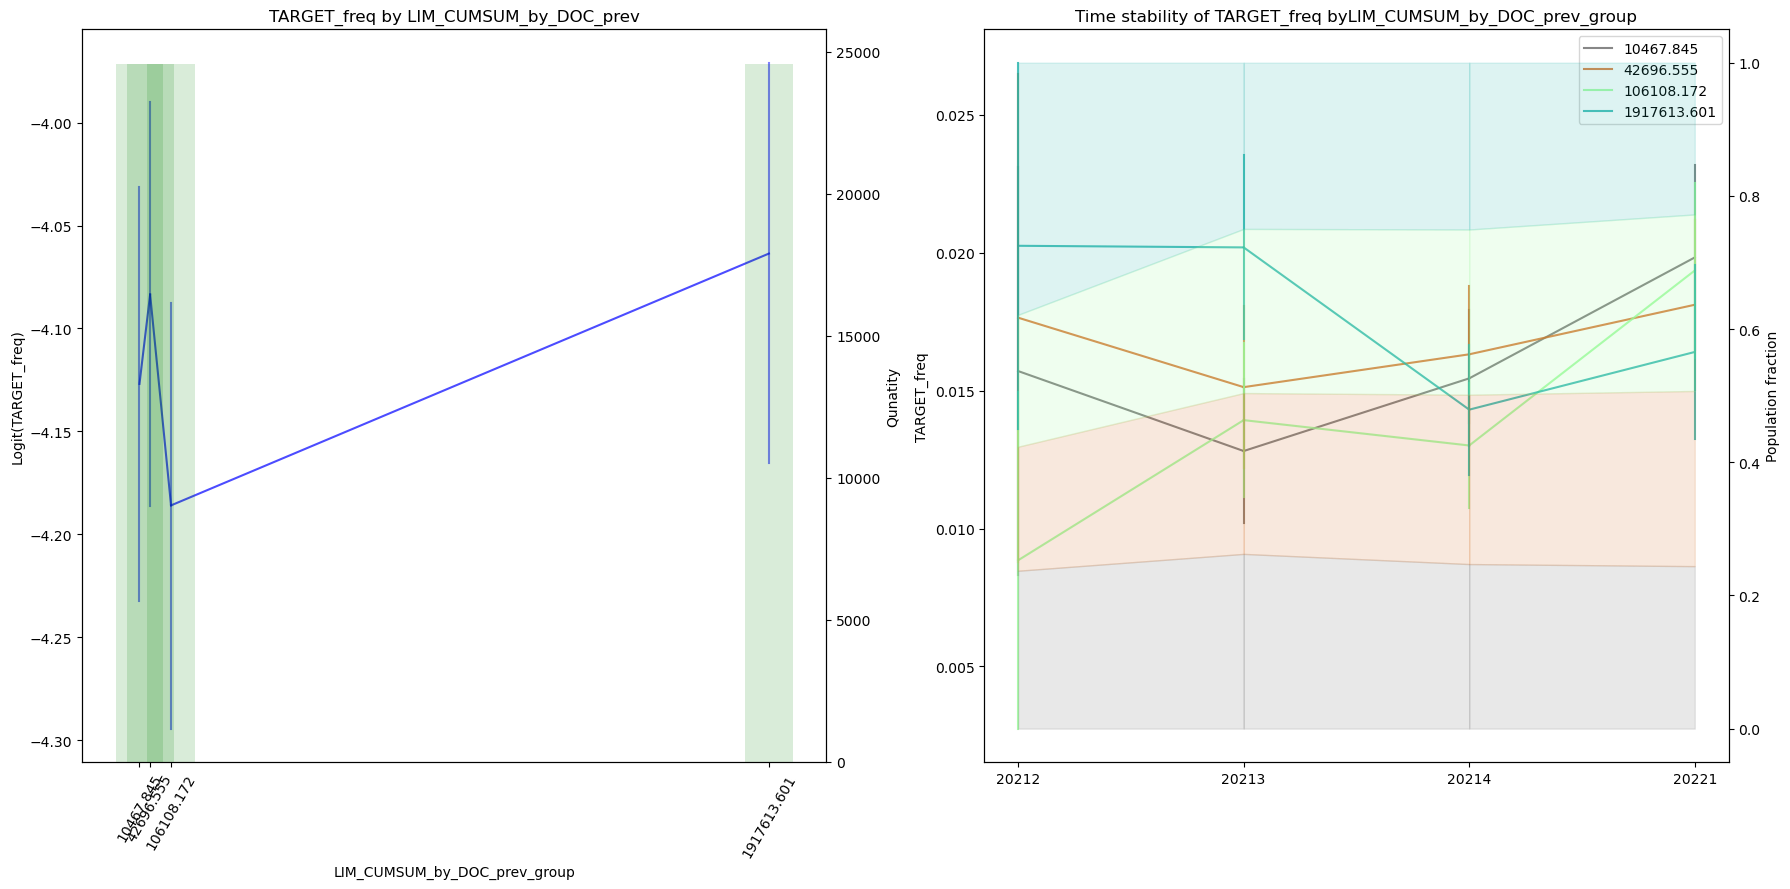

In [14]:
#Lets make one dimensional analysis of aggregate features
df_copy['EMAIL_num_by_DOC_1'] = df_copy['EMAIL_num_by_DOC'].clip(0, 5)
df_copy['APP_rank_by_DOC_1'] = df_copy['APP_rank_by_DOC'].clip(0, 5)
df_copy['edinici'] = 1


qwe = one_dim_analysis(df = df_copy,
                prop = 'EMAIL_num_by_DOC_1',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 6,
                time_flag = True,
                bootstrap = False
                )

qwe = one_dim_analysis(df = df_copy,
                prop = 'APP_rank_by_DOC_1',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 6,
                time_flag = True,
                bootstrap = False
                )

qwe = one_dim_analysis(df = df_copy[df_copy['APP_rank_by_DOC'] == 2],
                prop = 'LIM_CUMSUM_by_DOC_prev',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = True,
                n_groups = 4,
                time_flag = True,
                bootstrap = False
                )

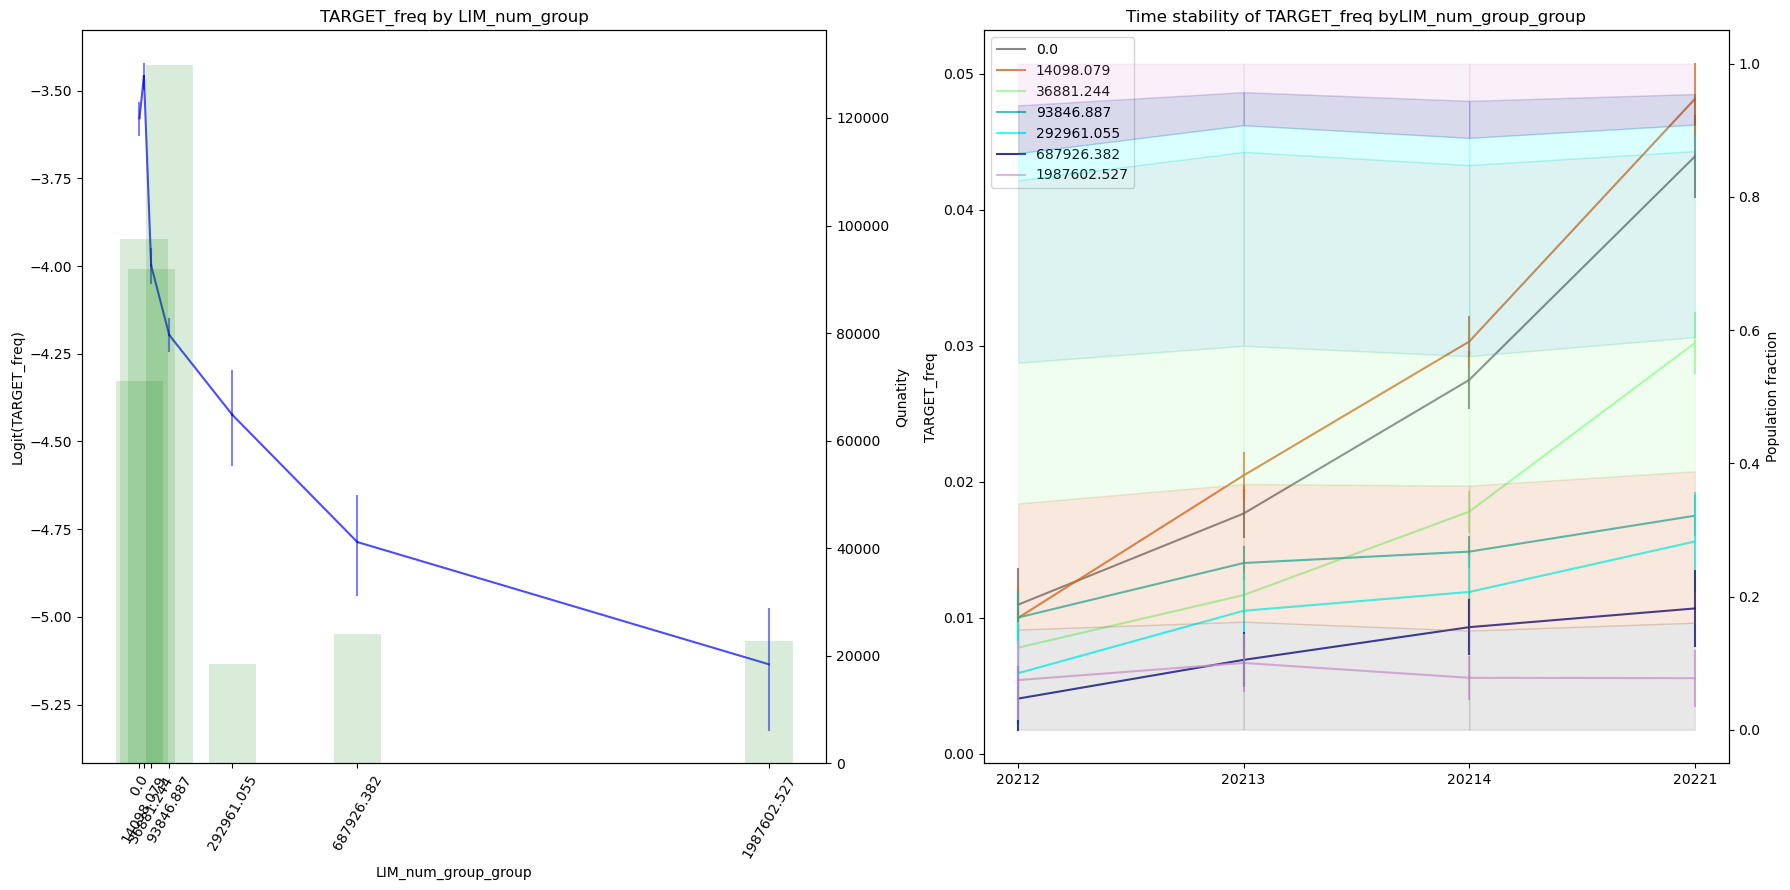

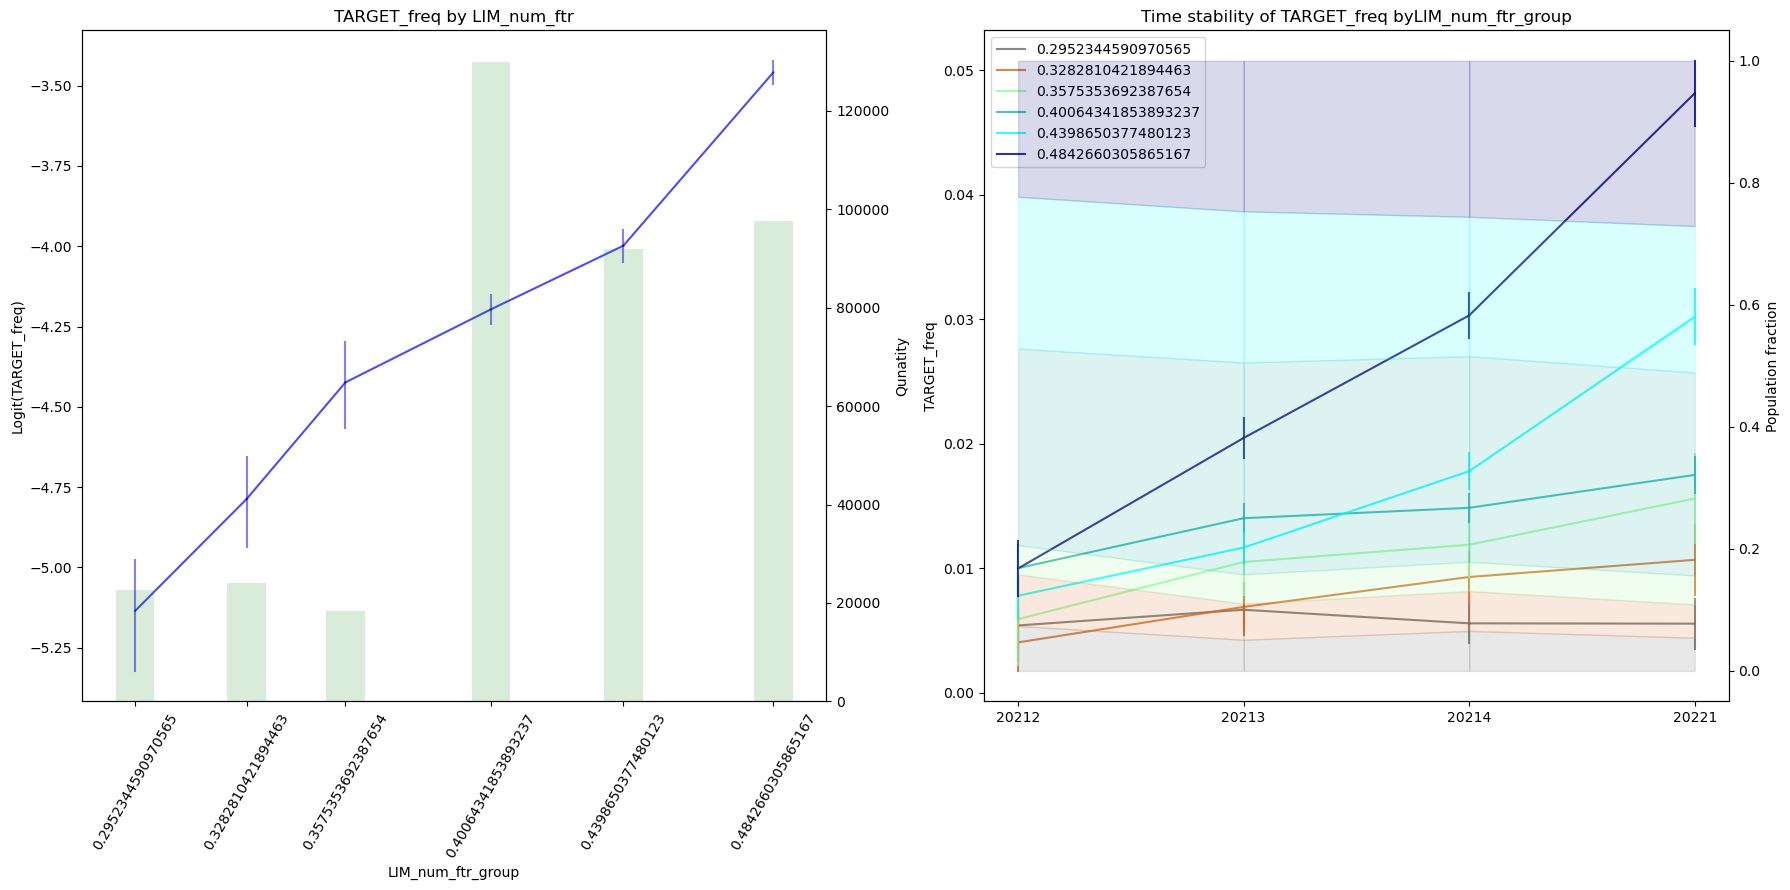

In [26]:
#Lets check LIM feature
df_copy = split_group(df_copy,
                      prop = 'LIM_num',
                      quantiles = False,
                      weight = 'edinici',
                      values = [0, 2.5e4, 5e4, 2e5, 4e5, 1e6]
                      )

qwe = one_dim_analysis(df = df_copy,
                prop = 'LIM_num_group',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 4,
                time_flag = True,
                bootstrap = False
                )

#Lets linearize it
df_copy['LIM_num_ftr'] = 1 / (0.1 * df_copy['LIM_num_group'].clip(lower = 1e4, upper = 2e6))**0.1 #Pareto distribution linearization


qwe = one_dim_analysis(df = df_copy[df_copy['LIM_num'] > 0],
                prop = 'LIM_num_ftr',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 5,
                time_flag = True,
                bootstrap = False
                )

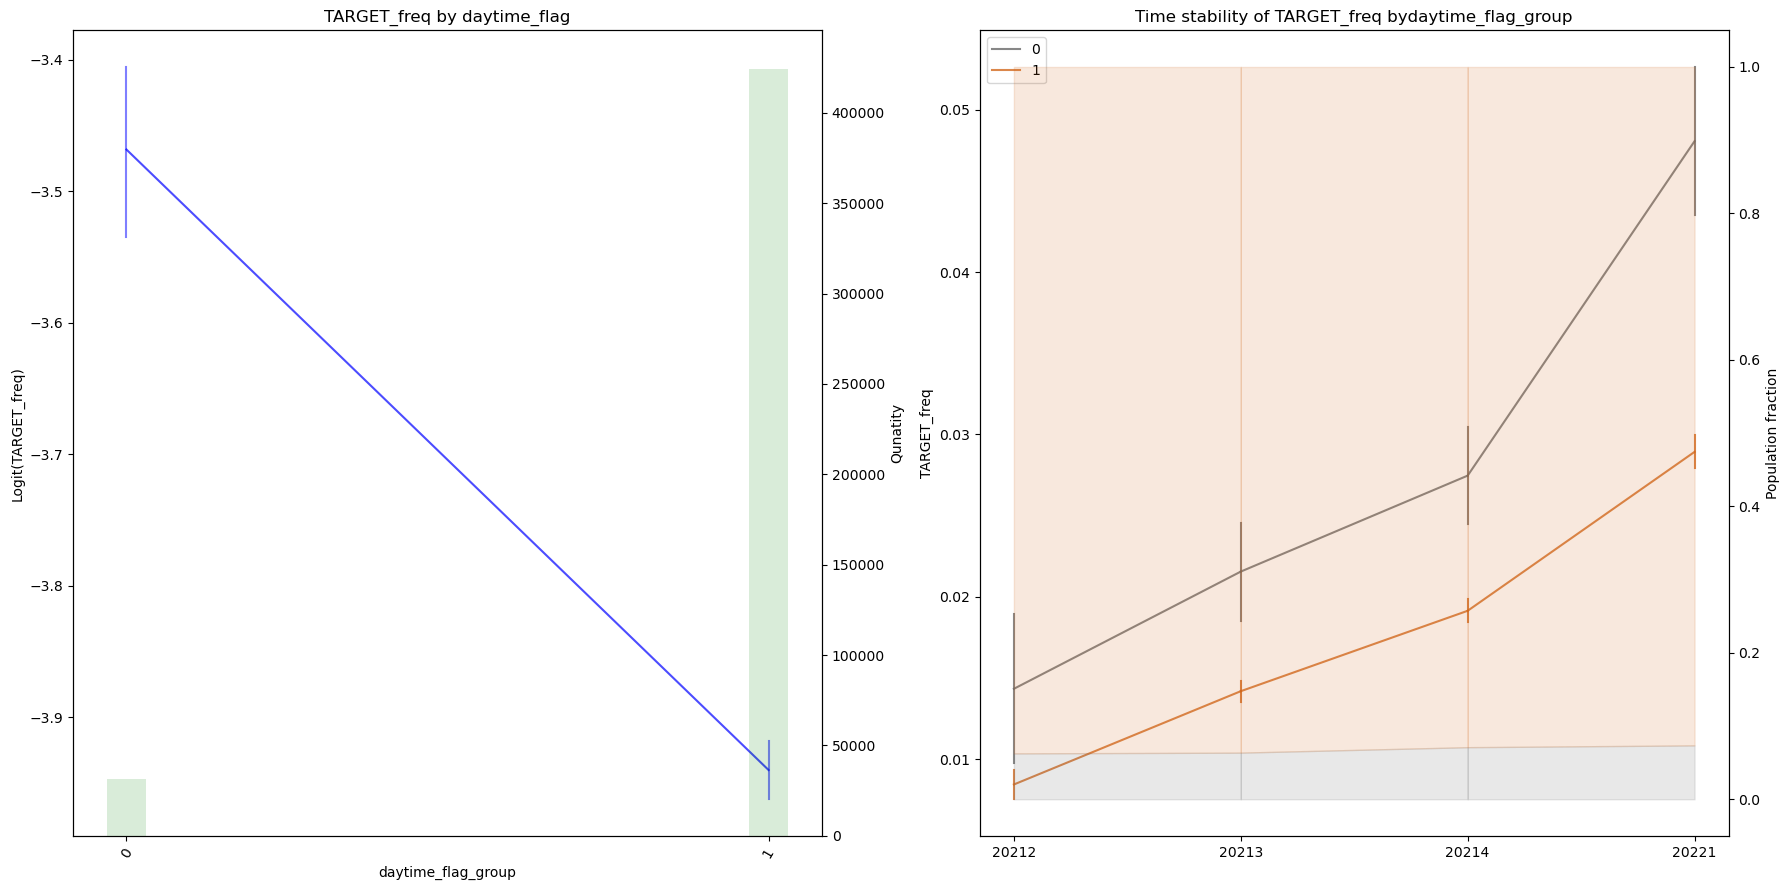

In [28]:
#Investigate night time feature
df_copy['daytime_flag'] = df_copy['hour'].apply(lambda x : 1 * (x <= 20) * (x >= 4))
qwe = one_dim_analysis(df = df_copy,
                prop = 'daytime_flag',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 5,
                time_flag = True,
                bootstrap = False
                )

In [9]:

df['EMAIL_ftr'] = df['EMAIL_num_by_DOC'].clip(0, 7)
df['APP_rank_ftr'] = df['APP_rank_by_DOC'].clip(0, 7)


df['LIM_ftr'] = 1 / (0.1 * df['LIM_num'].clip(lower = 1e4, upper = 2e6))**0.1
df['LIM_zero_flag'] = 1 * (df['LIM_num'] == 0)

df['daytime_flag'] = df['hour'].apply(lambda x : 1 * (x <= 20) * (x >= 4))

df[['APPID', 'APPDATE', 'EMAIL_ftr', 'APP_rank_ftr', 'LIM_ftr', 'LIM_zero_flag', 'daytime_flag', 'TARGET']].to_csv('linear_features.csv', index = False)